#Task 1 (30 points): Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Additionally, do the following:

In [1]:
# import the data
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


In [3]:
# https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
# this is the import code directly from the uci site

from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [4]:
# convert y to a numerical variable
y = np.where(y == 'M', 1, 0).reshape(-1, 1)

Xtrain, Xtemp, ytrain, ytemp = train_test_split(X, y, test_size=0.3, random_state=42)

Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size=0.5, random_state=42)

In [5]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

clf = DecisionTreeClassifier(random_state=42)
clf.fit(Xtrain, ytrain)
yhat = clf.predict(Xtest)
print(classification_report(ytest, yhat))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        60
           1       0.89      0.92      0.91        26

    accuracy                           0.94        86
   macro avg       0.93      0.94      0.93        86
weighted avg       0.94      0.94      0.94        86



##Task 1.1: Visualize the decision tree structure for at least three different parameter settings. Comment on how the depth and complexity change the tree.

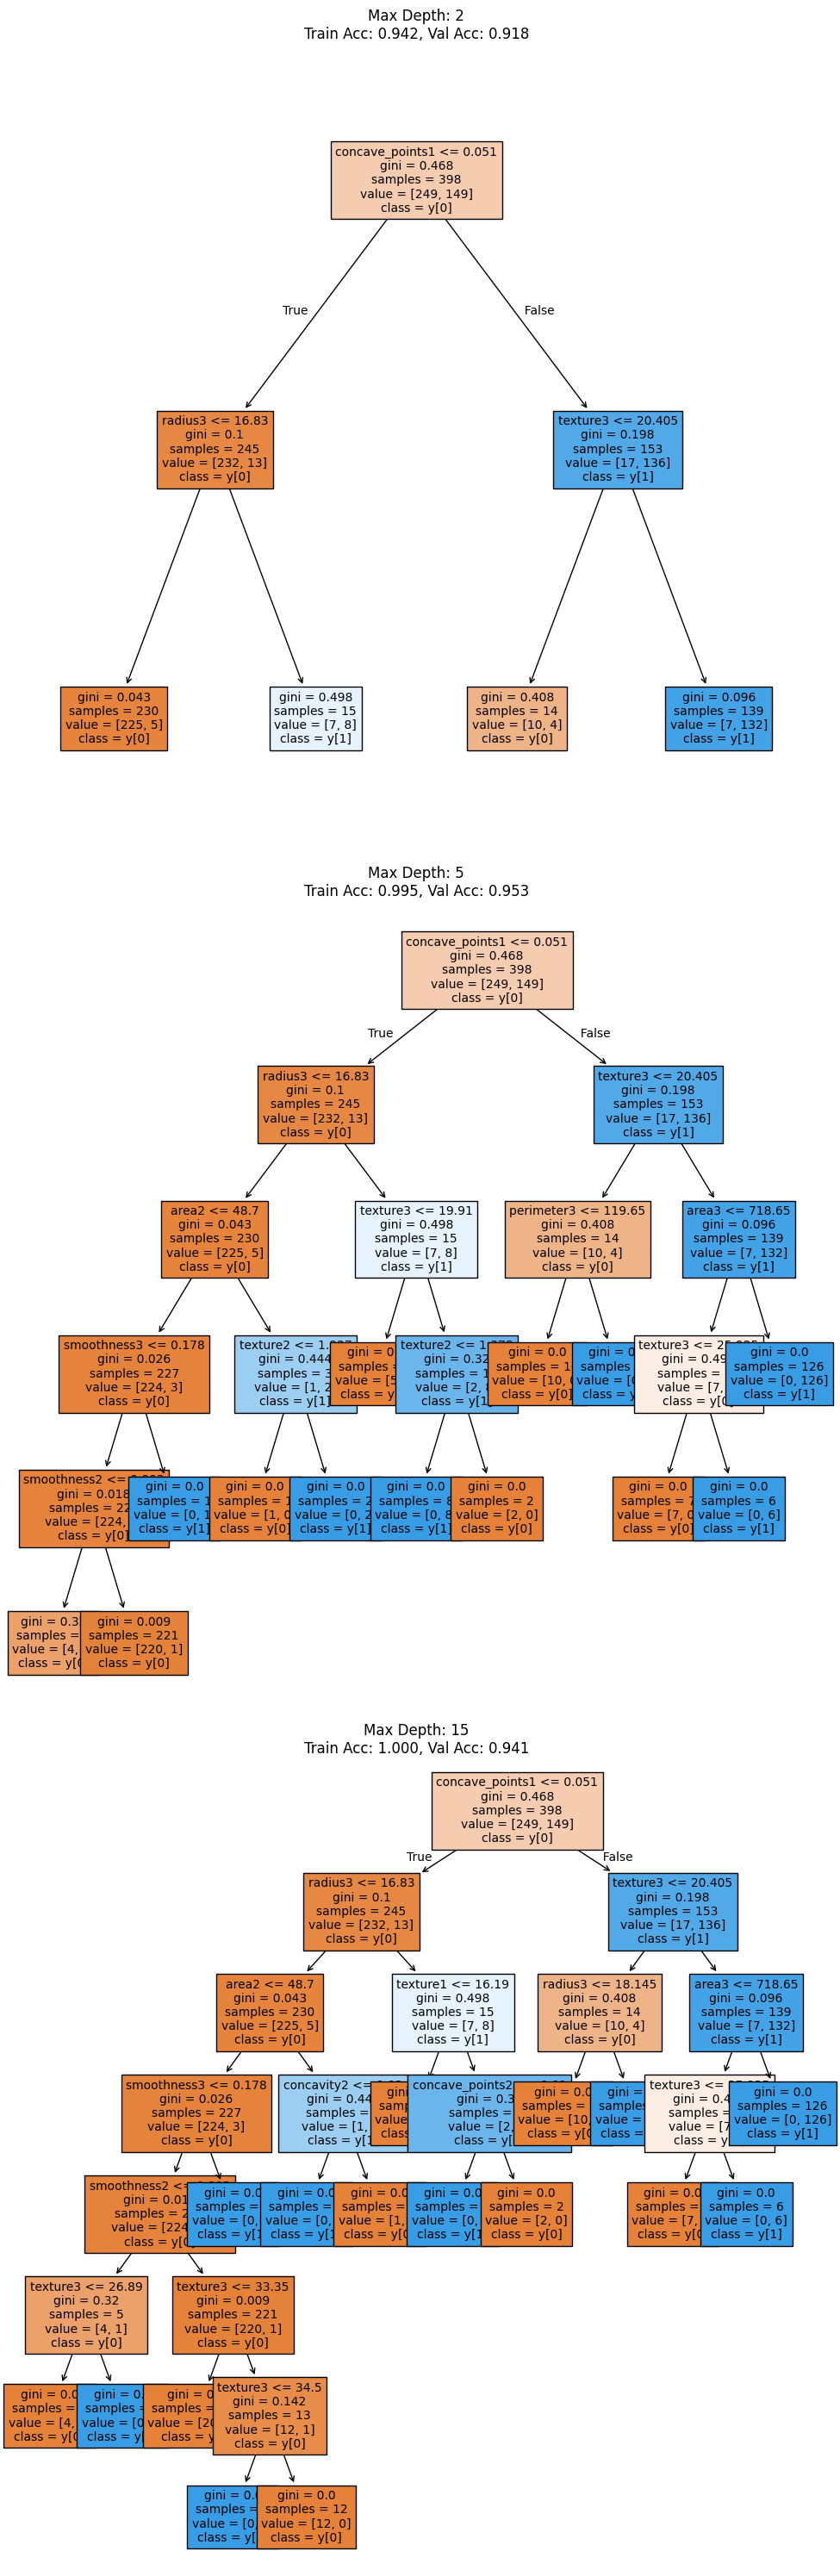

In [6]:
# three different depths (parameter settings)
depths = [2, 5, 15]
models = []

fig, axes = plt.subplots(3, 1, figsize=(10, 30))

for i, depth in enumerate(depths):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(Xtrain, ytrain)
    models.append(clf)

    trainAcc = accuracy_score(ytrain, clf.predict(Xtrain))
    valAcc = accuracy_score(yval, clf.predict(Xval))

    plot_tree(clf,
            feature_names=X.columns,
            class_names=True,
            filled=True,
            ax=axes[i],
            fontsize=10)
    axes[i].set_title(f"Max Depth: {depth}\nTrain Acc: {trainAcc:.3f}, Val Acc: {valAcc:.3f}")

plt.tight_layout()
plt.show()

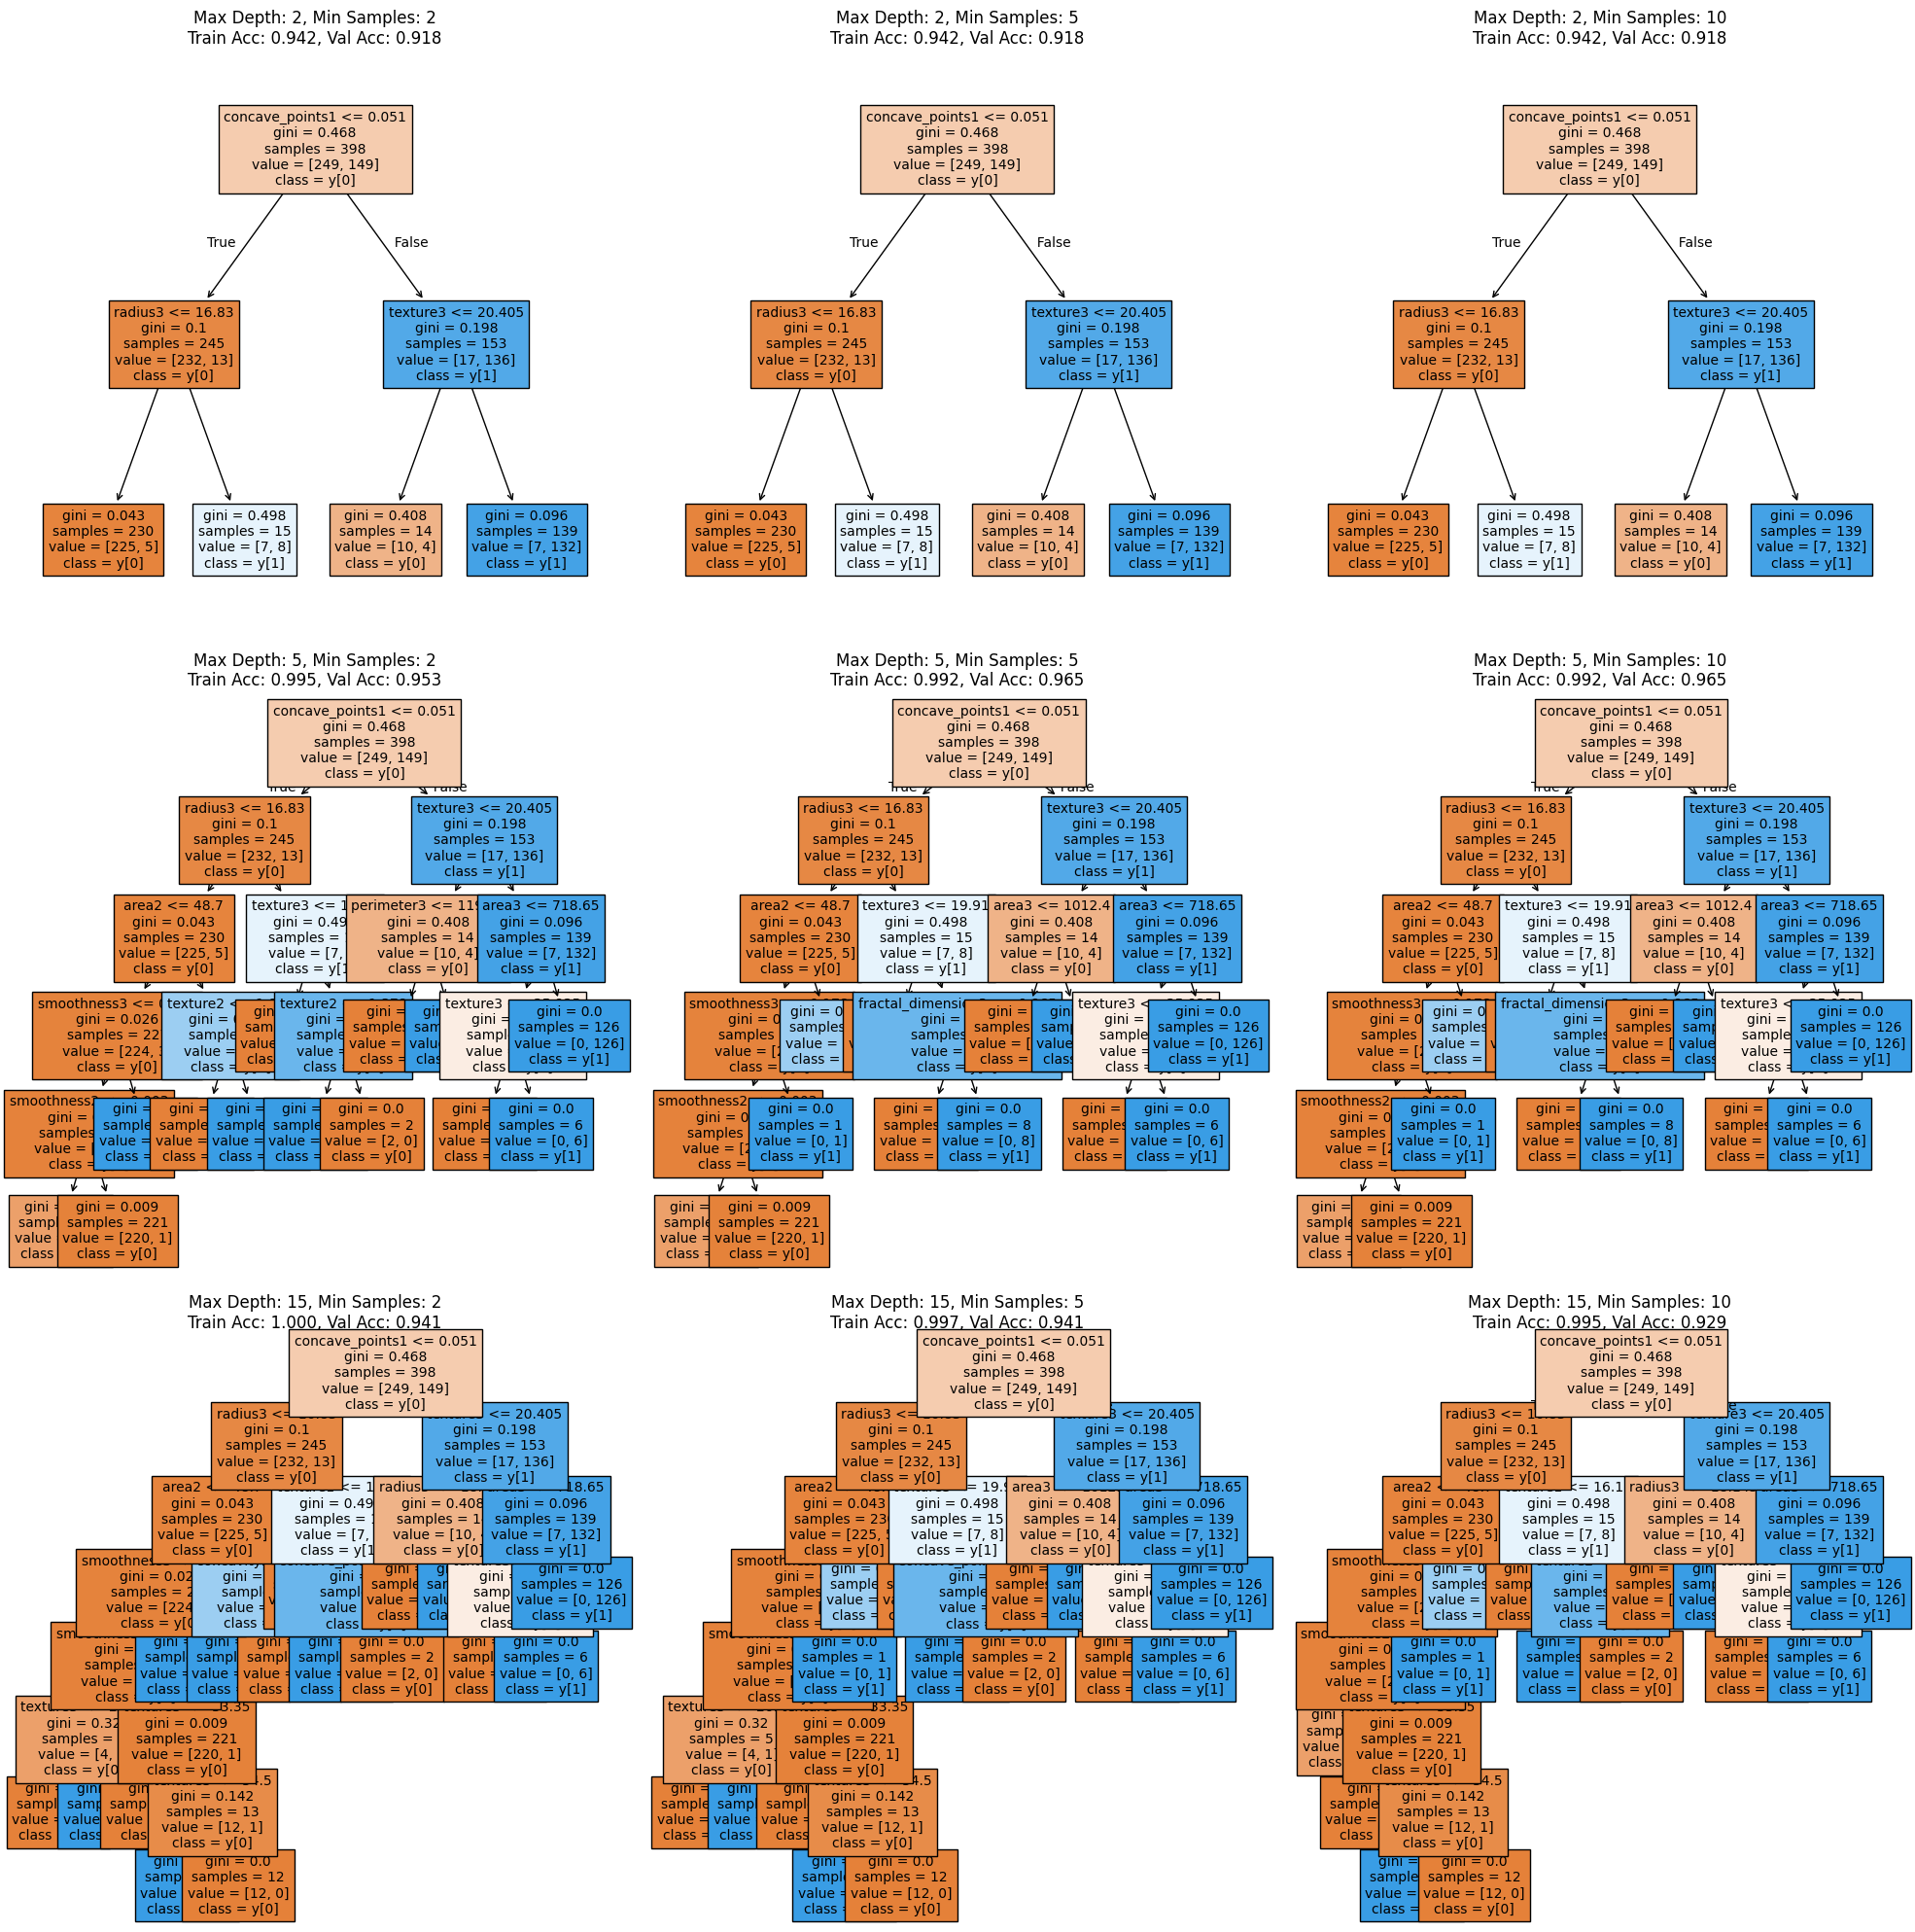

In [7]:
# nine different parameter settings
depths = [2, 5, 15]
minSamples = [2, 5, 10]
models = []

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

i = 0
for depth in depths:
    for minSample in minSamples:
        clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=minSample, random_state=42)
        clf.fit(Xtrain, ytrain)
        models.append(clf)

        trainAcc = accuracy_score(ytrain, clf.predict(Xtrain))
        valAcc = accuracy_score(yval, clf.predict(Xval))

        plot_tree(clf,
              feature_names=X.columns,
              class_names=True,
              filled=True,
              ax=axes[i],
              fontsize=10)
        axes[i].set_title(f"Max Depth: {depth}, Min Samples: {minSample}\nTrain Acc: {trainAcc:.3f}, Val Acc: {valAcc:.3f}")
        i += 1

plt.tight_layout()
plt.show()

We can see when little to no boundaries are put on the parameters, the tree starts agressively overfitting. This is evident by the MaxDepth=15 MinSamples=2 tree. The training accuracy is 100%, however, when asked to generalize to the vaalidation set, it has a horrible accuracy. My original hope was that instituting a higher MinSamples would help prevent such cases but regularizing the model, but we can see on MaxDepth=15 MinSamples=10, that it did not have too great of an effect. The tree at least does not have a 100% training accuracy, but its validation accuracy is also the worst out of all of the combinations.

I think it is fair to say that we found a happy medium with the MaxDepth=5. It has enough complexity to capture the patterns in the data, but not so much as too capture the trends that exclusively lie in the training set. This is why MaxDepth=5 was able to achieve the highest validation accuracy. Additionally, though the effects are still minimal, the highest validation accuracies did occur when MinSamples>2, so that is of some note.

##Task 1.2: Do some research on what sensitivity analysis is and how it is performed (include citations). Perform a sensitivity analysis to measure the impact of at least two input features on your model's decision boundary.

https://www.statology.org/how-to-perform-sensitivity-analysis-experiment-design-analysis/

https://pmc.ncbi.nlm.nih.gov/articles/PMC9605992/

Sensitivity analysis is building an understanding of the inputs affects on your eventual output. Sensitivity analysis helps one achieve a greater understanding of the model as whole by observing how it changes with input changes. This is very important for someone like myself who doesn't have too much domain knowledge, and therefore, cannot independently assess what features are going to be most important to the model.

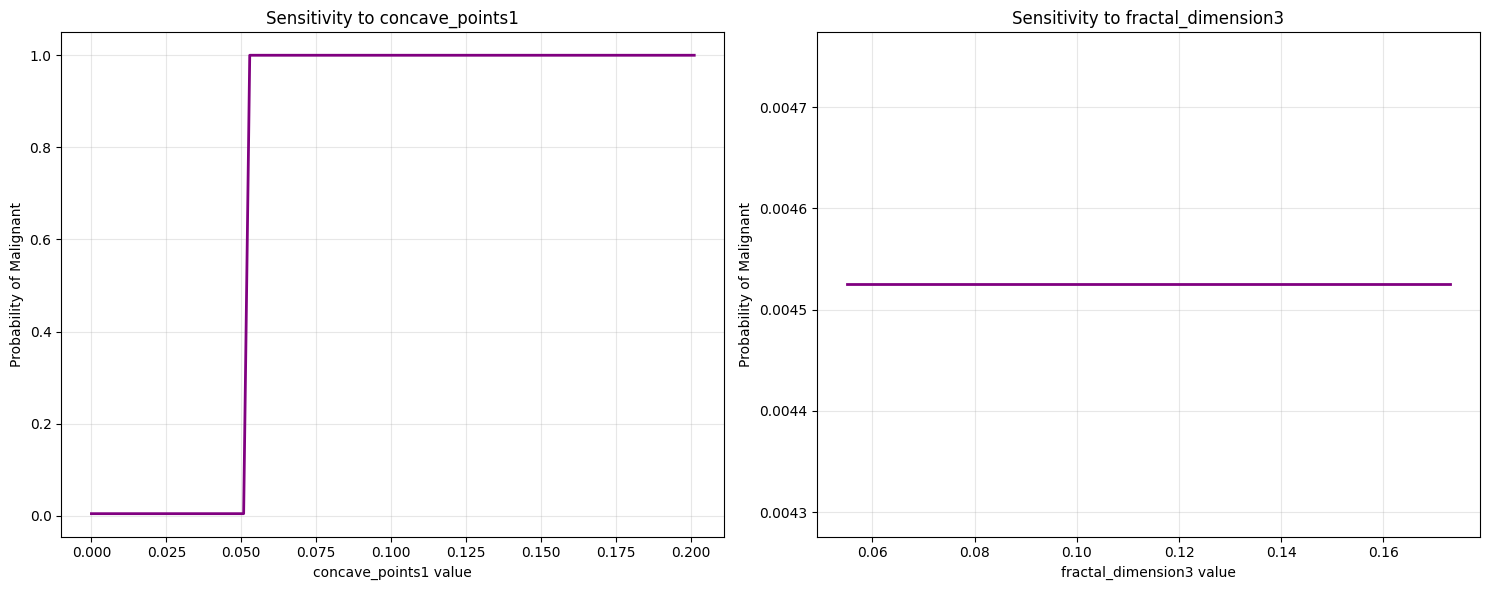

In [8]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=42)
dt.fit(Xtrain, ytrain)

importances = pd.Series(dt.feature_importances_, index=Xtrain.columns)
topFeat = importances.sort_values(ascending=False).head(5)

def plotFeatureSensitivity(model, feature, X, ax):
    minVal = X[feature].min()
    maxVal = X[feature].max()

    featureRange = np.linspace(minVal, maxVal, 100)

    baseRow = X.mean().to_frame().T

    syntheticData = pd.concat([baseRow] * 100, ignore_index=True)
    syntheticData[feature] = featureRange

    probs = model.predict_proba(syntheticData)[:, 1]

    ax.plot(featureRange, probs, linewidth=2, color='purple')
    ax.set_title(f"Sensitivity to {feature}")
    ax.set_xlabel(f"{feature} value")
    ax.set_ylabel("Probability of Malignant")
    ax.grid(True, alpha=0.3)

feat1 = topFeat.index[0]
feat2 = topFeat.index[-1]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plotFeatureSensitivity(dt, feat1, Xtrain, axes[0])
plotFeatureSensitivity(dt, feat2, Xtrain, axes[1])

plt.tight_layout()
plt.show()

I used the most important and least important features for the sensitivity analysis. We can see that very clearly in the resulting graphs. For concave_points1, there is a huge jump in the probability of a malignant classification when the value crosses the threshhold of about 0.5. Meanwhile, no such jump ever occurs from fractal_dimension3, the line just remains flat.

# Task 2 (30 points): From the Bagging and Boosting ensemble methods pick any one algorithm from each category. Implement both the algorithms using the same data.

For bagging I will be using a Random Forest Classifier. For boosting, I will be using XGBoost.

In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# implement a basic Random Forest Classifier

clf = RandomForestClassifier(random_state=42)
clf.fit(Xtrain, ytrain)
yhat = clf.predict(Xtest)
print(classification_report(ytest, yhat))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.92      0.96        26

    accuracy                           0.98        86
   macro avg       0.98      0.96      0.97        86
weighted avg       0.98      0.98      0.98        86



In [10]:
# https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html
# implement a basic xgboost classifier

clf = XGBClassifier(random_state=4)
clf.fit(Xtrain, ytrain)
yhat = clf.predict(Xtest)
print(classification_report(ytest, yhat))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.93      0.96      0.94        26

    accuracy                           0.97        86
   macro avg       0.95      0.96      0.96        86
weighted avg       0.97      0.97      0.97        86



##Task 2.1: Use stratified k-fold cross-validation with at least three different folds (e.g., 5, 10, 15). You may do your own research on this technique (include citations).

In [11]:
# https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/
# https://www.datasciencebase.com/supervised-ml/optimization-tuning/cross-validation-techniques-hyperparameter-tuning/
# https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-stratified-k-fold-cross-validation-for-unbalanced-data-014691060f17
# https://mljourney.com/best-practices-for-cross-validation-in-machine-learning/

folds = [5, 10, 15]
bestRfAccuracy = -1
bestXgbAccuracy = -1
bestRfFold = None
bestXgbFold = None

rfModel = RandomForestClassifier(n_estimators=100, random_state=42)
xgbModel = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

for fold in folds:
    skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
    rfScores = cross_val_score(rfModel, Xtrain, ytrain.ravel(), cv=skf, scoring='accuracy')
    print(f"Random Forest Classifier with {fold} folds: {rfScores.mean():.3f}")

    xgbScores = cross_val_score(xgbModel, Xtrain, ytrain.ravel(), cv=skf, scoring='accuracy')
    print(f"XGBoost Classifier with {fold} folds: {xgbScores.mean():.3f}")
    print()

    if rfScores.mean() > bestRfAccuracy:
        bestRfAccuracy = rfScores.mean()
        bestRfFold = fold
    if xgbScores.mean() > bestXgbAccuracy:
        bestXgbAccuracy = xgbScores.mean()
        bestXgbFold = fold


Random Forest Classifier with 5 folds: 0.960
XGBoost Classifier with 5 folds: 0.957

Random Forest Classifier with 10 folds: 0.950
XGBoost Classifier with 10 folds: 0.965

Random Forest Classifier with 15 folds: 0.947
XGBoost Classifier with 15 folds: 0.963



##Task 2.2: Evaluate the models using any three-evaluation metrics of your choice (e.g. accuracy, Precision, F1-score etc.).


In [12]:
evalMetrics = ['accuracy', 'precision', 'recall', 'f1']

rfScores = cross_validate(rfModel, Xtrain, ytrain.ravel(), cv=bestRfFold, scoring=evalMetrics)

print(f"Random Forest Classifier with {bestRfFold} folds:")
print(f"Accuracy: {rfScores['test_accuracy'].mean():.3f}")
print(f"Precision: {rfScores['test_precision'].mean():.3f}")
print(f"Recall: {rfScores['test_recall'].mean():.3f}")
print(f"F1: {rfScores['test_f1'].mean():.3f}")
print()

xgbScores = cross_validate(xgbModel, Xtrain, ytrain.ravel(), cv=bestXgbFold, scoring=evalMetrics)
print(f"XGBoost Classifier with {bestXgbFold} folds:")
print(f"Accuracy: {xgbScores['test_accuracy'].mean():.3f}")
print(f"Precision: {xgbScores['test_precision'].mean():.3f}")
print(f"Recall: {xgbScores['test_recall'].mean():.3f}")
print(f"F1: {xgbScores['test_f1'].mean():.3f}")
print()


Random Forest Classifier with 5 folds:
Accuracy: 0.950
Precision: 0.945
Recall: 0.919
F1: 0.932

XGBoost Classifier with 10 folds:
Accuracy: 0.965
Precision: 0.966
Recall: 0.940
F1: 0.952



## Task 2.3: Comment on the behavior of each algorithm under the metrics. Does the performance ranking change based on the metric used? Why?

The Xgboost outperformed the RF in every metric. This suggestgs that boosting is the better approach for this classification task rather than bagging. The F1 score, in both cases, is very high showing that they are both effective models nonetheless.

Going back to the domain, medicine and predicting cancer, there are some concerns with the scores shown. Both of the accuracies are extrordinarily high, but for both, the recall is the lowest score. For our domain, we want recall to be the highest. This is because in cancer diagnoses, a false negative is the worst outcome, and recall is a good measure of how good we are at preventing that.

An additional note, the different models had different folds that they performed best with. Therefore, I used 10 folds for the Xgboost and 5 for the RF.

# Task 3 (40 points): Compare the effectiveness of the three models implemented above. Analyze the results using the following:


## Task 3.1: A confusion matrix for one selected test fold.

In [13]:
# the confusion matrices will be calculated using Fold 1 from a 5-Fold stratified cross validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for foldIndex, (trainIndex, testIndex) in enumerate(skf.split(Xtrain, ytrain)):
    if foldIndex == 0:   # ← SELECTED FOLD
        XtrainFold, XtestFold = Xtrain.iloc[trainIndex], Xtrain.iloc[testIndex]
        ytrainFold, ytestFold = ytrain[trainIndex], ytrain[testIndex]
        break


# decision tree model with MaxDepth=5, MinSamples=5
dtModel = DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=42)
dtModel.fit(XtrainFold, ytrainFold.ravel())
dtPredictions = dtModel.predict(XtestFold)

# clean rfModel
rfModel = RandomForestClassifier(n_estimators=100, random_state=42)
rfModel.fit(XtrainFold, ytrainFold.ravel())
rfPredictions = rfModel.predict(XtestFold)

# clean xgbModel
xgbModel = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=4)
xgbModel.fit(XtrainFold, ytrainFold.ravel())
xgbPredictions = xgbModel.predict(XtestFold)

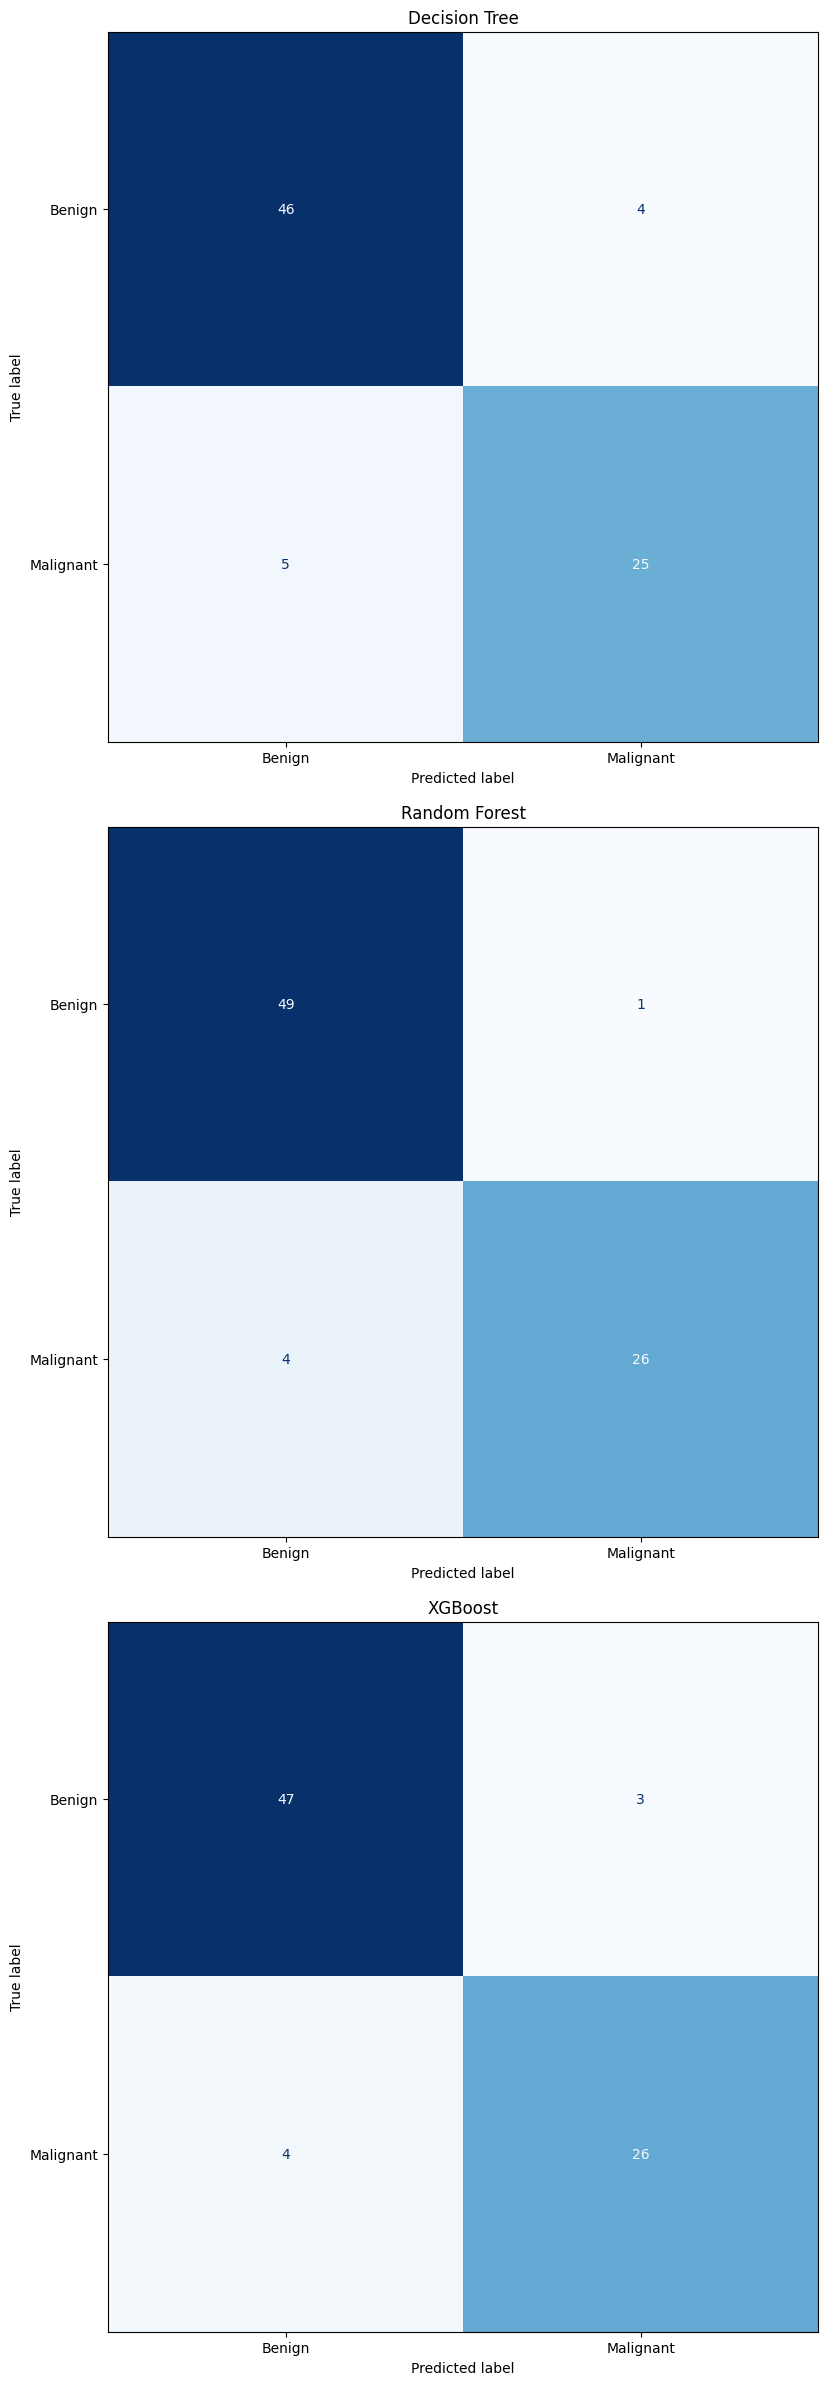

In [14]:
# print the confusion matrices

models = { "Decision Tree": dtPredictions, "Random Forest": rfPredictions, "XGBoost": xgbPredictions }
fig, axes = plt.subplots(3, 1, figsize=(8, 24))

for i, (model, predictions) in enumerate(models.items()):
    cm = confusion_matrix(ytestFold, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
    axes[i].set_title(model)

plt.tight_layout()
plt.show()


When looking at the resulting confusion matrices, it is quite evident that all of the models are extremely similar. No number varies more than +/- 3 in any quandrant across all three models. This makes it hard to distinguish them by eye. This, of course, is in part because of the size of the test set. With only 85 items in the test set, there isn't really a large enough sample size to properly distinguish very high performing models.

## Task 3.2: A statistical test (e.g., paired t-test) to determine if differences between models are significant.

In [15]:
# decision tree model
dtScores = cross_val_score(dtModel, Xtrain, ytrain.ravel(), cv=10)
# random forest model
rfScores = cross_val_score(rfModel, Xtrain, ytrain.ravel(), cv=10)
# xgboost model
xgbScores = cross_val_score(xgbModel, Xtrain, ytrain.ravel(), cv=10)

print(f"DT Mean Accuracy: {dtScores.mean():.3f}")
print(f"RF Mean Accuracy: {rfScores.mean():.3f}")
print(f"XGB Mean Accuracy: {xgbScores.mean():.3f}")

DT Mean Accuracy: 0.909
RF Mean Accuracy: 0.947
XGB Mean Accuracy: 0.965


In [16]:
def ttest(s1, s2, n1, n2):
    tstat, pval = stats.ttest_rel(s1, s2)
    print(f"Comparing {n1} and {n2}")
    print(f"t-statistic: {tstat:.3f}")
    print(f"p-value: {pval:.3f}")
    if pval < 0.05:
        print("Reject the null hypothesis (significant difference found)")
    else:
        print("Fail to reject the null hypothesis (no significant difference found)")
    print()

ttest(dtScores, rfScores, "Decision Tree", "Random Forest")
ttest(dtScores, xgbScores, "Decision Tree", "XGBoost")
ttest(rfScores, xgbScores, "Random Forest", "XGBoost")

Comparing Decision Tree and Random Forest
t-statistic: -3.518
p-value: 0.007
Reject the null hypothesis (significant difference found)

Comparing Decision Tree and XGBoost
t-statistic: -8.890
p-value: 0.000
Reject the null hypothesis (significant difference found)

Comparing Random Forest and XGBoost
t-statistic: -2.340
p-value: 0.044
Reject the null hypothesis (significant difference found)



After looking at the confusion matrices, I did not really expect this result, but I should have figured that this would be the case based on the results of Task 2.1. Xgboost stil remains on top, followed by RF and finally DT. Using a T-test, we have found that the differences in these models are actually statistically significant. Therefore, in a clinical setting, I would be remiss to suggest anything except Xgboost.

## Task 3.3: A discussion on the trade-off between bias and variance for each model.

Let us begin with DT. This algorithm has a low bias, and a high variance. This is because of it's highly flexible nature. It's ability to represent even the most complex boundaries lowers its bias. However, this become a detriment when there are slight differences between training and testing data as the model picks up on patterns exclusive to the training data.

Moving onto the RF. This had a statiscally significant increase in accuracy from the DT. This is because of its "bagging" methodology. It trains itself on multiple subsets of the data and averages all of the predictions. This protects itself from the overfitting tendencies of DT and lowers the variance, while not incurring a significant penalty in terms of bias.

Finally, we have the model that outperformed all, the Xgboost. This model seuqentially processes trees where each new tree tries to correct upon the mistakes of the prior. This also leads to a very low bias. In addition, it has several regularization techniques baked into the model which effectively regulate complexity. This keeps the model from overfitting to the training data. All of these mechanisms led to the most effective model allowing Xgboost to have a statistically significant improvement over its next closest model, RF.

# Task 4 (50 points): For the same classification problem solved above, implement the XGBoost algorithm. If you picked XGBoost as one of the boosting algorithms in task 2, you may use the same implementation. Implement and evaluate XGBoost with the following requirements:

## Task 4.1: Perform a grid search or random search over at least 3 hyperparameters, such as learning rate, max depth, and subsample.

In [17]:
# https://mljourney.com/how-to-tune-xgboost-hyperparameters/
# https://xgboosting.com/grid-search-xgboost-hyperparameters/
# https://woteq.com/how-to-use-xgboost-with-gridsearchcv-for-hyperparameter-tuning/
# https://www.geeksforgeeks.org/machine-learning/comparing-randomized-search-and-grid-search-for-hyperparameter-estimation-in-scikit-learn/

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.75, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=4, eval_metric='logloss'),
    param_grid=param_grid,
    cv=5,            # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1        # Use all available processors
)

grid_search.fit(Xtrain, ytrain.ravel())

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")

bestXgb = grid_search.best_estimator_
testAccuracy = bestXgb.score(Xtest, ytest)
print(f"Test accuracy: {testAccuracy:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best accuracy: 0.9823
Test accuracy: 1.0000


## Task 4.2: Analyze the sensitivity of your model to changes in these parameters.

The highest sensitivity, by far, is to the learning rate. The lower learning rate, 0.01, resulted in a significantly lower cv accuracy. Though much closer in results, the accuracy achieved with 0.2 learning rate was always greater than that of 0.1. These results show that a far more aggressive learning rate is very effective in this model.

To my great suprise, the model had a very low sensitivity to max depth. At every learning rate, the depth remained the same. This suggests that the patterns that needed to be found in this data set were not too complex. Therefore, a shallower tree could get the job done just as well as a deeper more complex one.

The model improved with a greated number of estimators. Dramatically so with a lower learning rate, and more gradually with the higher ones.

Additionally, the subsample was also very sensitive to the learning rate. At a learning rate of 0.1, it was rather unaffected. However, accuracy was very dramatically affected by subsample when the learning rates were 0.01 and 0.2.

The final optimized solution favored a higher learning rate (0.2) and higher n_estimators (200). This showed that the dataset's patterns were simple enough for shallow trees, as seen in the low depth sensitivity, but the model required a high learning speed and data exposure (subsample) to achieve its peak performance.

## Task 4.3: Optional (no points taken off if not done) - Create plots to show the effect of each parameter on accuracy and another metric.


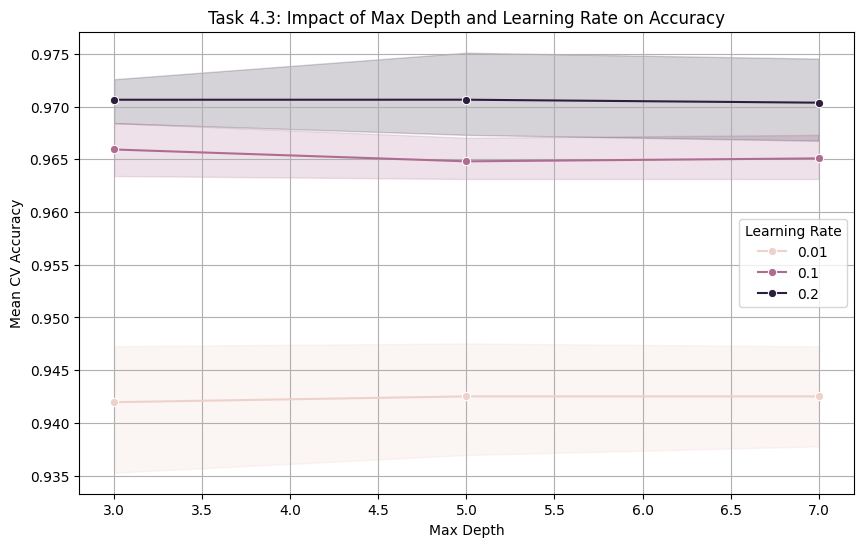

In [18]:
# Convert results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Plotting the effect of Max Depth and Learning Rate on Accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_max_depth', y='mean_test_score', hue='param_learning_rate', marker='o')
plt.title('Task 4.3: Impact of Max Depth and Learning Rate on Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

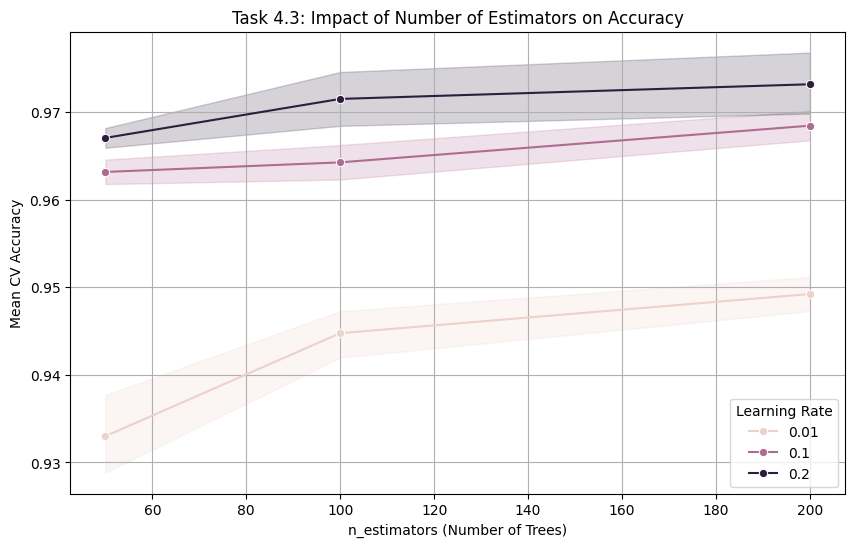

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate', marker='o')

plt.title('Task 4.3: Impact of Number of Estimators on Accuracy')
plt.xlabel('n_estimators (Number of Trees)')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

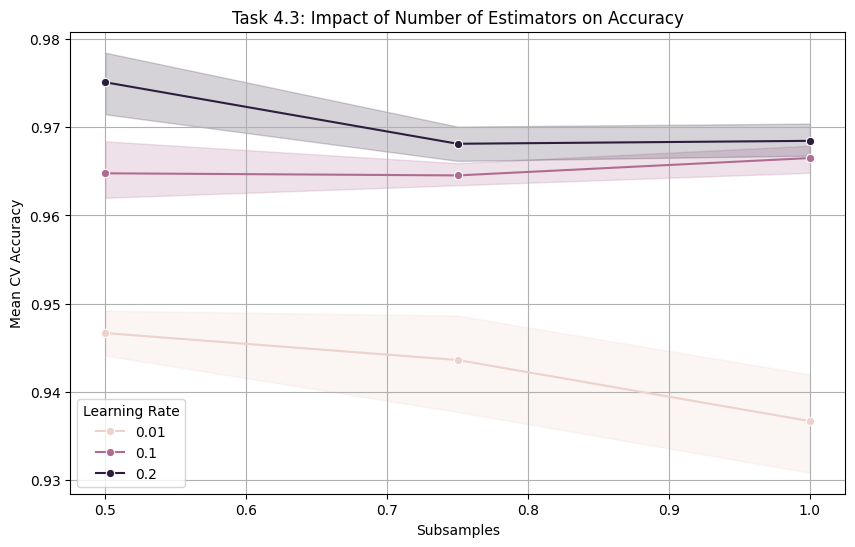

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_subsample', y='mean_test_score', hue='param_learning_rate', marker='o')

plt.title('Task 4.3: Impact of Number of Estimators on Accuracy')
plt.xlabel('Subsamples')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()